In [ ]:
import math

In [2]:
import matplotlib.pyplot as plt

In [3]:
import fuzzy
import fuzzy.storage.fcl.Reader
from fuzzy.doc.plot.gnuplot import doc

# Считывание FIS

In [4]:
system = fuzzy.storage.fcl.Reader.Reader().load_from_file("FIS/lab4-const.fcl")

# Sugeno FIS с постоянными выходами

In [5]:
def prepaire_input(temperature, pressure):
    
    sys_input = {
        'water': temperature,
        'pressure': pressure
    }
    
    return sys_input

In [6]:
def prepaire_output():
    sys_output = {
        'craneCold': 0, 
        'craneHot': 0
    }
    
    return sys_output

In [7]:
def generate_temperature(time):

    t_cold = 15 + 10 * math.sin(float(math.pi * time) / 50 + 20)
    t_hot = 60 + 20 * math.sin(float(math.pi * time) / 60)
    
    return (t_cold, t_hot)

In [8]:
def result_temperature(t_cold, t_hot, q_cold, q_hot):
    return (t_cold * q_cold + t_hot * q_hot) / (q_cold + q_hot)

In [9]:
def result_pressure(q_cold, q_hot):
    return (q_cold + q_hot) / 2

In [10]:
MINS = 5
STEP_SECS = 1

STEPS = int(MINS * 60 / STEP_SECS)

TEMPERATURES = list()
PRESSURES = list()

t_c, t_h = generate_temperature(0)
q_c = q_h = 1e-15

for t in range(1, STEPS):
    
    Q = result_pressure(q_c, q_h)
    T = result_temperature(t_c, t_h, q_c, q_h)
    
    in_sys = prepaire_input(T, Q)
    out_sys = prepaire_output()
    
    out_sys = system.calculate(in_sys, out_sys)
    
    q_cold = out_sys['craneCold']
    q_hot = out_sys['craneHot']
    
    q_c += q_cold
    q_h += q_hot
    
    TEMPERATURES.append(T)
    PRESSURES.append(Q)
        
    t_c, t_h = generate_temperature(t)    

## Температура от времени

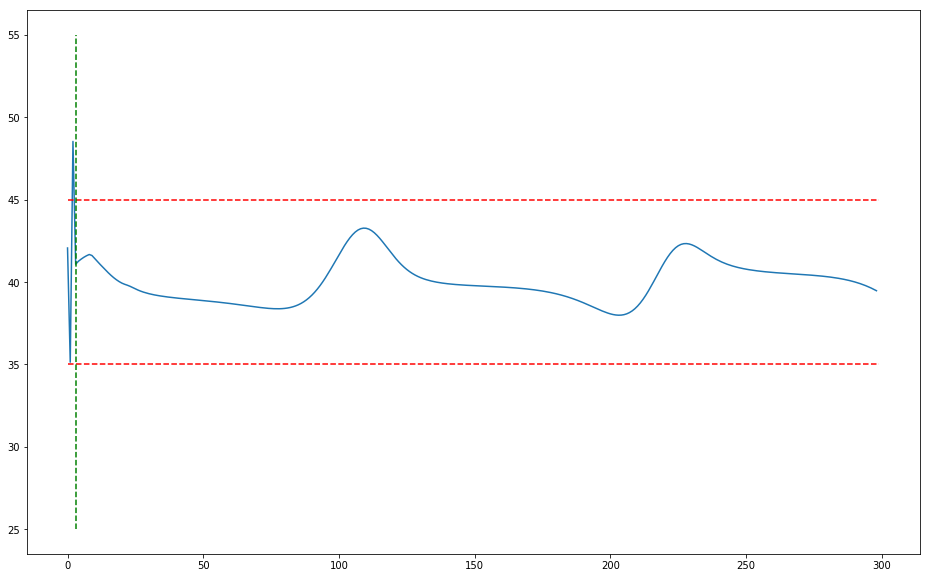

In [11]:
plt.figure(figsize=(16, 10))
plt.plot(TEMPERATURES)
plt.plot([0, len(TEMPERATURES)], [45, 45], '--r')
plt.plot([0, len(TEMPERATURES)], [35, 35], '--r')
plt.plot([3, 3], [25, 55], '--g')
plt.show()

### На 4-й секунде температура становится комфортной

## Напор от времени

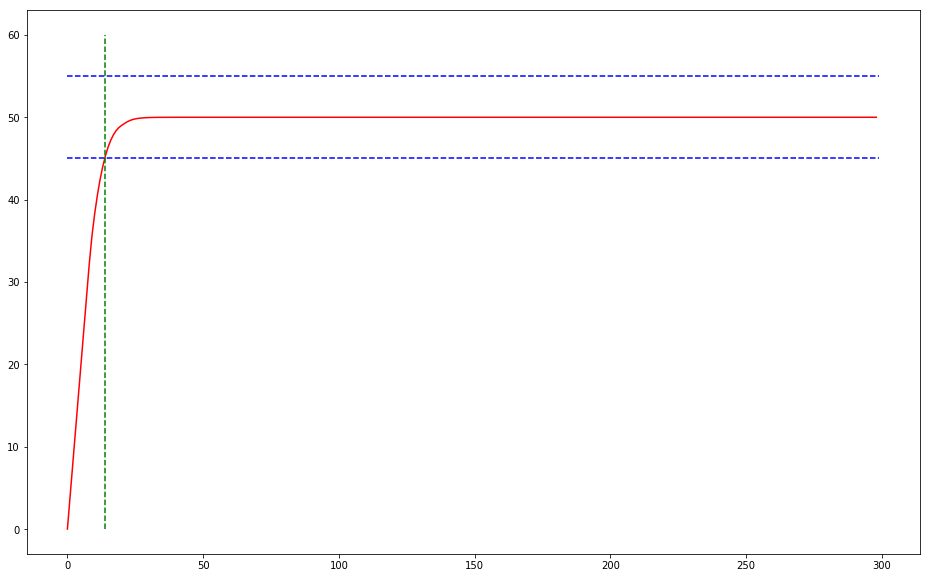

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(PRESSURES, 'r')
plt.plot([0, len(PRESSURES)], [45, 45], '--b')
plt.plot([0, len(PRESSURES)], [55, 55], '--b')
plt.plot([14, 14], [0, 60], '--g')
# plt.plot(PRESSURES, 'ob')
# plt.title('Напор воды')
plt.show()

### На 14-й секунде становится становится комфортным

# Sugeno FIS с линейными выходами

In [204]:
system = fuzzy.storage.fcl.Reader.Reader().load_from_file("FIS/lab4-linear.fcl")

In [212]:
def hot_crane(T, Q, level=1):
    'level = 1 - сильно-повернуть'
    'level = 2 - немного повернуть'
    'level = 3 - не трогать'
    
    if level == 2:
        return -2 * (T - 40) - 0.4 * (Q - 50)
    elif level == 1:
        return -1 * (T - 40) - 0.2 * (Q - 50)
    elif level == 3:
        return 0

In [213]:
def cold_crane(T, Q, level=1):
    'level = 1 - сильно-повернуть'
    'level = 2 - немного повернуть'
    'level = 3 - не трогать'
    
    if level == 2:
        return 2 * (T - 40) - 0.4 * (Q - 50)
    elif level == 1:
        return (T - 40) - 0.2 * (Q - 50)
    elif level == 3:
        return 0

In [223]:
MINS = 3
STEP_SECS = 1

STEPS = int(MINS * 60 / STEP_SECS)

TEMPERATURES = list()
PRESSURES = list()

QC = list()
QH = list()

t_c, t_h = generate_temperature(0)
q_c = q_h = 1e-15

for t in range(STEPS):
    
    Q = result_pressure(q_c, q_h)
    T = result_temperature(t_c, t_h, q_c, q_h)
    
    in_sys = prepaire_input(T, Q)
    out_sys = prepaire_output()
    
    
    try:
        out_sys = system.calculate(in_sys, out_sys)
    except Exception as e:
        print(out_sys)
        
#     print(out_sys)
        
    q_cold = out_sys['craneCold']
    q_hot = out_sys['craneHot']
    
    if q_cold < 10:
        q_cold = cold_crane(T, Q, level=3)
    elif q_cold < 20:
        q_cold = cold_crane(T, Q, level=2)
    elif q_cold < 30:
        q_cold = cold_crane(T, Q, level=1)
        
    if q_hot < 10:
        q_hot = hot_crane(T, Q, level=3)
    elif q_hot < 20:
        q_hot = hot_crane(T, Q, level=2)
    elif q_hot < 30:
        q_hot = hot_crane(T, Q, level=1)
        
    q_c += q_cold
    q_h += q_hot

    QC.append(q_c)
    QH.append(q_h)
    
#     print q_c, q_h
        
    TEMPERATURES.append(T)
    PRESSURES.append(Q)
        
    t_c, t_h = generate_temperature(t)    

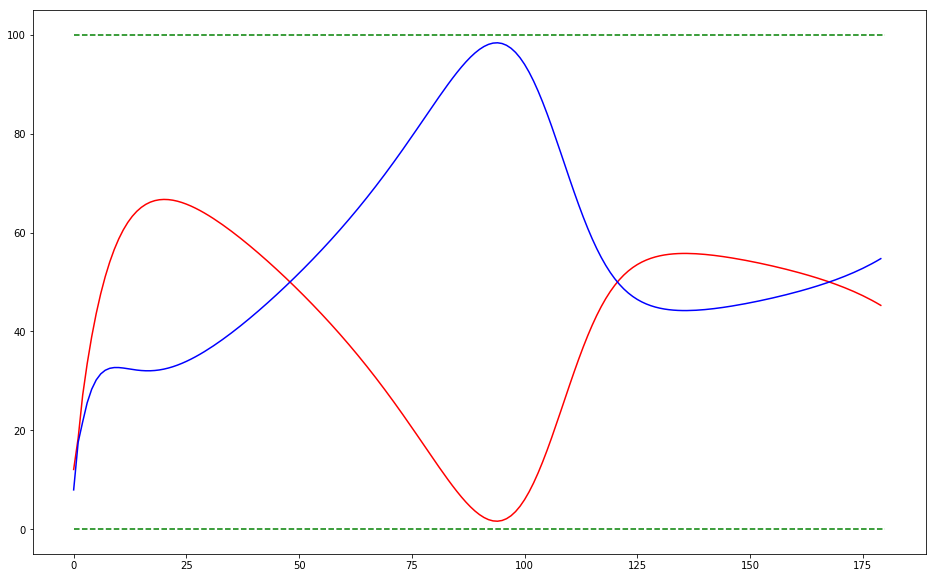

In [224]:
plt.figure(figsize=(16, 10))
plt.plot(QC, 'r')
plt.plot(QH, 'b')
plt.plot([0, len(QC)], [0, 0], '--g')
plt.plot([0, len(QC)], [100, 100], '--g')
plt.show()

## Температура воды

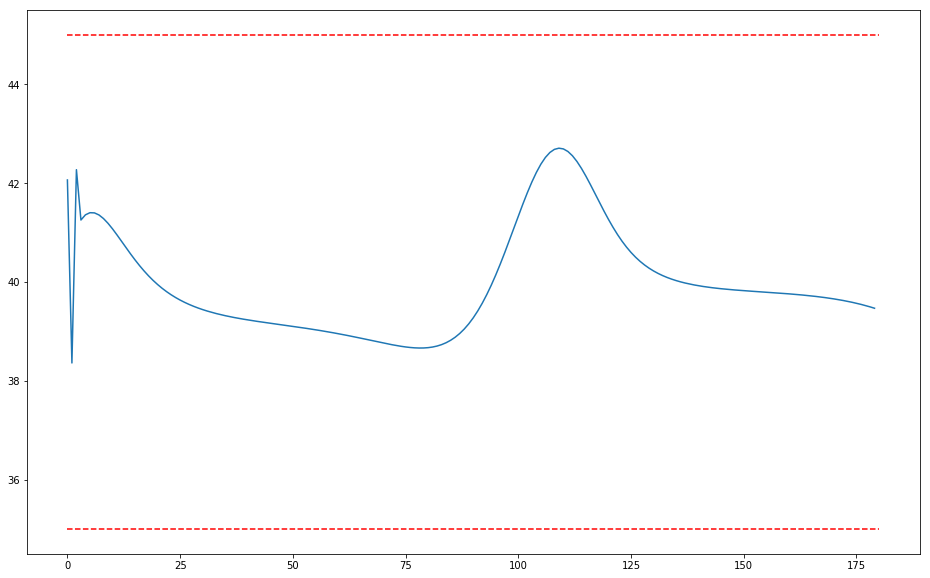

In [221]:
plt.figure(figsize=(16, 10))
plt.plot(TEMPERATURES)
plt.plot([0, len(TEMPERATURES)], [45, 45], '--r')
plt.plot([0, len(TEMPERATURES)], [35, 35], '--r')
# plt.plot([3, 3], [25, 55], '--g')
plt.show()

## Напор воды 

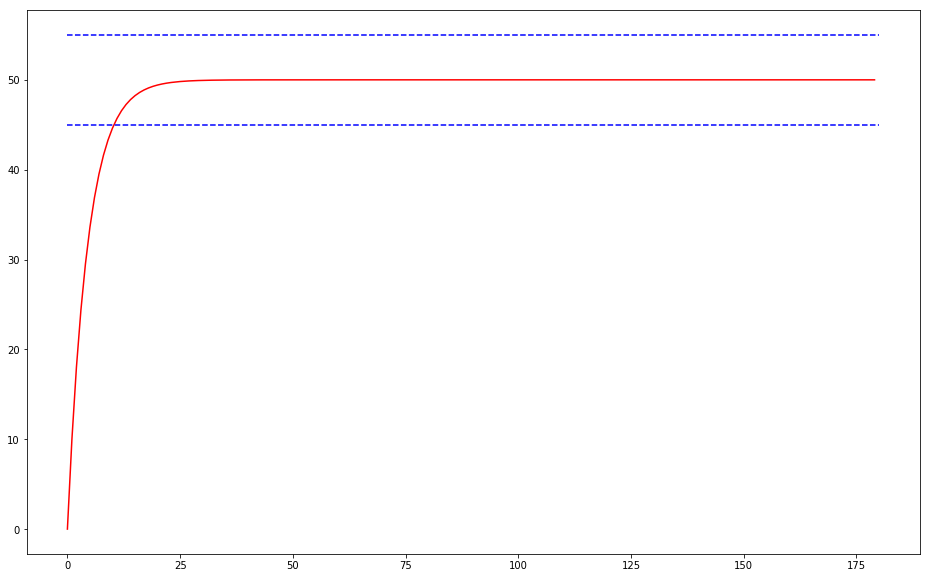

In [222]:
plt.figure(figsize=(16, 10))
plt.plot(PRESSURES, 'r')
plt.plot([0, len(PRESSURES)], [45, 45], '--b')
plt.plot([0, len(PRESSURES)], [55, 55], '--b')
# plt.plot([14, 14], [0, 60], '--g')
# plt.plot(PRESSURES, 'ob')
# plt.title('Напор воды')
plt.show()